## Learning objectives

- Appropriately split a dataset into training and test sets
- Recognize overfitting and/or underfitting by looking at train and test scores
- Explain why it is generally not possible to get a perfect test score (zero test error) on a supervised learning problem
- Describe the fundamental tradeoff between training score and the train-test gap
- Compare and contrast training, validation, test and deployment sets/scenarios
- Explain cross-validation 
- Perform cross-validation using `cross_val_score` and `cross_validate` in scikit-learn
- Start to build a standard recipe for supervised learning: train/test split, hyperparameter tuning with cross-validation, test on test set.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

from plot_classifier import plot_classifier

In [8]:
df = pd.read_csv('data/330-students-cilantro.csv')
df.columns = ["meat", "grade", "cilantro"]
df_nodup = df.sort_values(by="cilantro").drop_duplicates(subset=df.columns[:-1]).reset_index(drop=True)
X_nodup = df_nodup[["meat", "grade"]]
y_nodup = df_nodup["cilantro"]

## Splitting your data

Important question: how does accuracy change vs. max_depth?

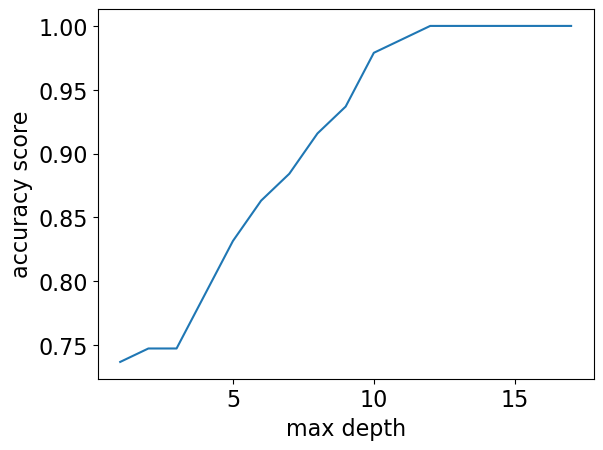

In [10]:
max_depths = np.arange(1, 18)
scores = []
for max_depth in max_depths:
    score = DecisionTreeClassifier(max_depth=max_depth).fit(X_nodup, y_nodup).score(X_nodup, y_nodup)
    scores.append(score)
plt.plot(max_depths, scores);
plt.xlabel("max depth");
plt.ylabel("accuracy score");

- We could also look at the same plot but flip the $y$ axis. 
- Currently it is accuracy, or % correct. But we can also do error, or % incorrect, which is very common:

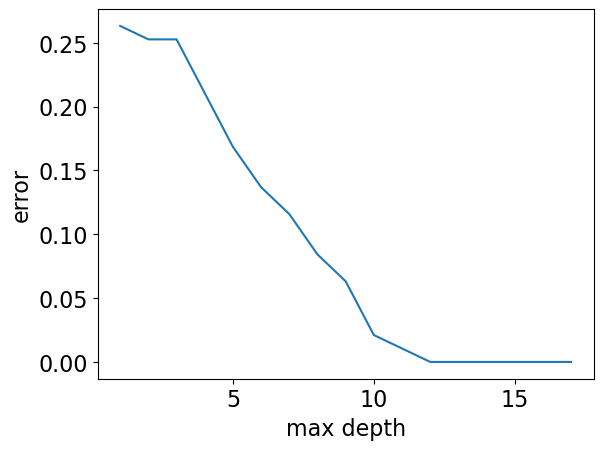

In [12]:
plt.plot(max_depths, 1-np.array(scores))
plt.xlabel("max depth");
plt.ylabel("error");

- Why not just use a very deep decision tree for every supervised learning problem and get super high accuracy?
- Well, the goal of supervised learning is to predict unseen/new data...
  - The above decision tree has 100% accuracy on the training data **where we already know the answer**.
  - It perfectly labels the data we used to make the tree...
  - But we want to know how our model performs on data not used in training.
  - We will split our original dataset into two parts, one for "training" and one for "testing".

In [14]:
df_train, df_test = train_test_split(df_nodup, random_state=123)

<img src="img/train-test-split.png" width="800">

Note: `train_test_split` splits randomly. 

- If you just took the top part and the bottom part of your dataframe, you could get terrible results.
- E.g. if they were sorted by one of the columns.
- **Make sure you split randomly** ideally be using a function like `train_test_split`.

Continuing on:

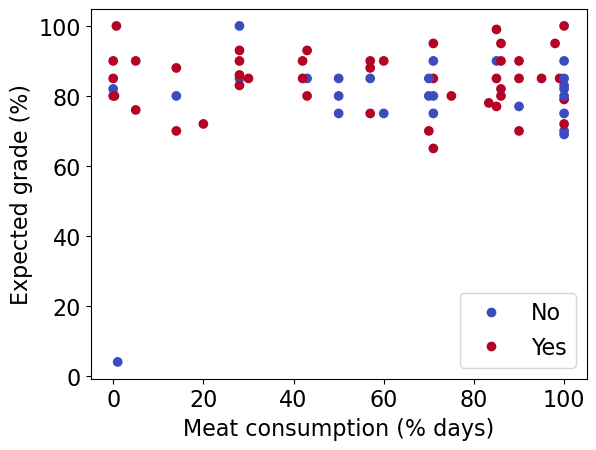

In [20]:
scatter = plt.scatter(df_train["meat"], df_train["grade"], c=df_train["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

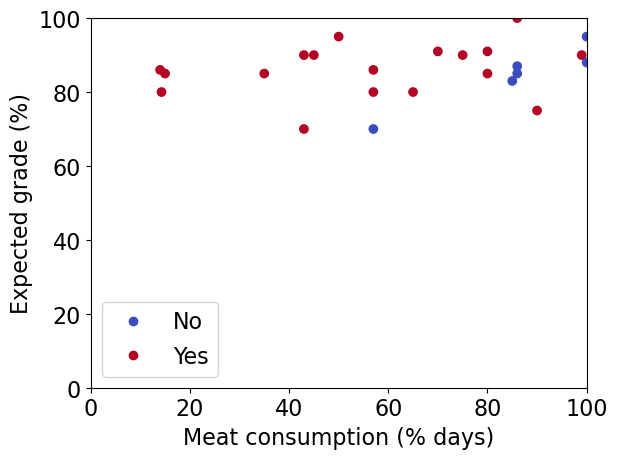

In [22]:
scatter = plt.scatter(df_test["meat"], df_test["grade"], c=df_test["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.xlim((0,100));
plt.ylim((0,100));
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

In [16]:
X_train = df_train[["meat", "grade"]]
y_train = df_train["cilantro"]
X_test  = df_test[["meat", "grade"]]
y_test  = df_test["cilantro"]

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train);

In [26]:
plot_classifier(X_train, y_train, tree, ticks=True, lims=(0,100,0,100), vmin=0, vmax=1);

TypeError: plot_classifier() got an unexpected keyword argument 'lims'

In [28]:
plot_classifier(X_test, y_test, tree, ticks=True, lims=(0,100,0,100), vmin=0, vmax=1);

TypeError: plot_classifier() got an unexpected keyword argument 'lims'

- The plot above shows the boundaries from the tree trained on **training data**, but the points shown are **test data**.
- In this plot we can see some mistakes.

In [18]:
tree.score(X_train, y_train)

1.0

In [20]:
tree.score(X_test, y_test)

0.5

- Our accuracy on the testing data is lower than on the training data. This phenomenon is called **overfitting**.
- Sometimes overfitting can be totally disastrous. 
- One way to combat this issue is to reduce the max depth!
- We're really just at the tip of the iceberg here - overfitting is a huge problem in machine learning and there are many ways to (try to) deal with it. 

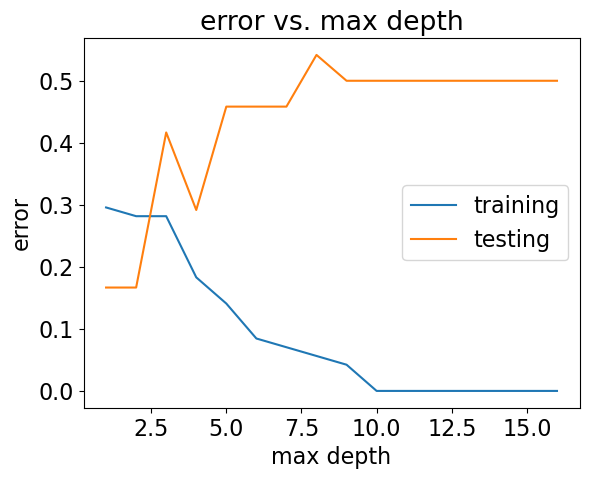

In [22]:
def make_traintest_plot(X_train, y_train, X_test, y_test):

    max_depths = np.arange(1, 17)
    train_error = []
    test_error = []
    for depth in max_depths:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=1)
        tree.fit(X_train, y_train)  
        train_error.append(1 - tree.score(X_train, y_train))
        test_error.append(1 - tree.score(X_test, y_test))

    f = plt.figure()
    plt.plot(max_depths, train_error, label="training");
    plt.plot(max_depths, test_error, label="testing");
    plt.xlabel("max depth");
    plt.ylabel("error");
    plt.title("error vs. max depth");
    plt.legend();
    return f

f = make_traintest_plot(X_train, y_train, X_test, y_test)

## Sources of error

We're going to think about 3 types of error:

- $E_\textrm{train}$ is your training error.
- $E_\textrm{test}$ is your test error.
- $E_\textrm{best}$ is the best possible error you could get for a given problem.

Q: why is $E_\textrm{best}>0$ ?
<br>
Ans: Duplicate data, randomness...
<br><br>
think about a data set with no features. you're trying to predict whether or not a person likes cilantro and you know nothing about them. well in that case all you can really do is predict that they like cilantro because most people like cilantro. there is a best error for this problem. if three quarters of the world like cilantro the best accuracy you can hope to get on average is 75 or an error of 25 because you don't have any more information. 

why is the error not zero? it's because the output (the y / the target variable) is not going to be an exact deterministic function of the input variables. if it was, like if you eat meat every day, then you like cilantro. if that's the way the world was, sure you could get 100 accuracy. but the world is never like that and so there could be randomness and that's why it's non-zero. 

it could just be the fact that there's not enough signal (there's not enough information in the features you have) to perfectly predict the thing you're trying to predict every single time. even if you do have features, they're not going to tell you perfectly exactly everything to always predict it exactly right and so that's why e-best is not zero.


output is not a known fixed function of the input so you never really have enough information to to perfectly predict every time.

best means low error rate in general that's right so we want to get low error, high accuracy.
<br><br>

- Let's think about a dataset with no features. 
- In that case, all you can do is what `DummyClassifier` does. 
- So in this case there's a "best error" since you cannot do better than that with no features. 
- If there are features, we'll be able to do better.
- With this `DummyClassifier` scenario $E_\textrm{best} = E_\textrm{train} = E_\textrm{test}$.

In [24]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train, y_train);
dc.score(X_train, y_train)

0.6338028169014085

In [26]:
dc.score(X_test, y_test)

0.75

- But the scores aren't the same?
- This is where everything gets tricky.
- They will be the same **on average** because both sets are just random samples from the data.
- But they may not be the same in a specific case.
- The more data you have, the closer they will be (law of large numbers).

Next scenario: a dataset with random features and a deep decision tree.

In [28]:
X_train_random = np.random.rand(len(y_train), 10)
X_test_random = np.random.rand(len(y_test), 10)

Q: what is $E_\textrm{best}$ here?

<br><br>

A: $E_\textrm{best}$ is still the same as before, because the features are not useful, but $E_\textrm{train}$ **is lower now**. $E_\textrm{test}$ may get higher due to overfitting.

In [30]:
tree = DecisionTreeClassifier()
tree.fit(X_train_random, y_train)
tree.score(X_train_random, y_train)

1.0

In [32]:
tree.score(X_test_random, y_test)

0.5

So here, in this overfitting scenario $E_\textrm{train}<E_\textrm{best}<E_\textrm{test}$.

Next scenario: our cilantro dataset

- In this case, assuming there is any actual relationship between the features and the target, we can start lowering $E_\textrm{best}$.
- The more "signal" (information about the target) is contained in the features, the lower $E_\textrm{best}$ can go.
- But it won't go to zero on a real dataset, because **the target is not a fixed deterministic function of the features** in basically any real case.
  - There is always some "unexplained" part or "random" part.
- To make matters worse, and this is one of the biggest challenges in supervised learning, you never know what $E_\textrm{best}$ actually is.

#### Standard overfitting scenario

$E_\textrm{train}<E_\textrm{best}<E_\textrm{test}$

- If $E_\textrm{train}$ is low, that is the overfitting scenario. It is fairly common to have at least a bit of this.
- $E_\textrm{test}$ cannot be smaller than $E_\textrm{best}$ basically by definition. In reality you won't have them equal.

#### Standard underfitting scenario

$E_\textrm{best}<E_\textrm{train}\lesssim E_\textrm{test}$

- In that case your model is too simple, e.g. `DecisionTreeClassifier` with `max_depth=1` or `DummyClassifier`
- The model is so simple that it doesn't even capture the patterns **in the training data**.
- So even the training error is not that low.
- In this case, you likely have very little overfitting (because you have very little fitting, period); hence $E_\textrm{train}\lesssim E_\textrm{test}$

#### Standard question to ask yourself

Which of these scenarios am I in?

Q: How can you figure this out?

<br><br><br><br>

A: You can't see $E_\textrm{best}$ but you can see $E_\textrm{train}$ and $E_\textrm{test}$. 

- If they are very far apart, you are more likely in the overfitting regime. Try decreasing model complexity.
- If they are very close together, you are more likely in the underfitting regime. Try increasing model complexity.

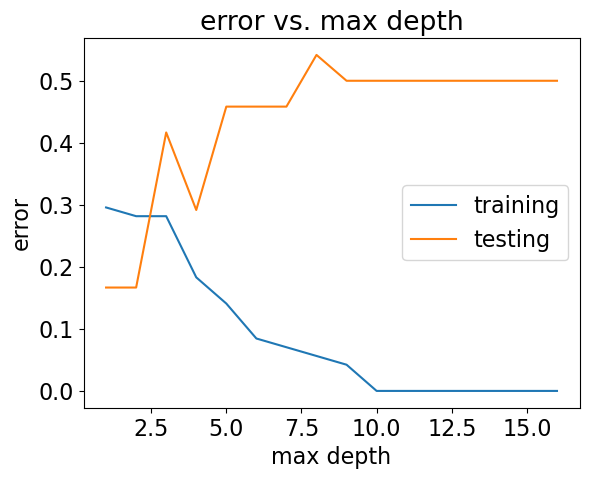

In [34]:
f

Can we find the underfitting and overfitting regimes?

- This cilantro dataset is a bit difficult to deal with because there's hardly any signal (my bad).
- In hw2 you'll work with a more reasonable dataset and get something like this:

![](img/spotify_scores.png)

Here we see the more typical behaviour where the test accuracy (flipped things here) goes up and then tapers off or goes back down.

## The fundamental trade-off

The "fundamental tradeoff" of supervised learning: 

> As you increase model complexity, $E_\textrm{train}$ tends to go down but $E_\textrm{test}-E_\textrm{train}$ tends to go up.

- If your model is very simple, like `DummyClassifier`, then you won't really learn any "specific patterns" of the training set, but your model won't be very good in general. This is **underfitting**.
- If your model is very complex, like a `DecisionTreeClassifier(max_depth=None)`, then you will learn crazy patterns that get every single training example correct, but there will be a huge gap between training error and test error. This is **overfitting**.

Note: this fundamental trade-off also called the [bias/variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) in statistics.

## True/False

1. In supervised learning, the training error is always lower than the test error.
2. The fundamental tradeoff of ML states that as training error goes down, test error goes up.
3. More "complicated" models are more likely to overfit than "simple" ones.
4. It is possible to construct a problem with $E_\textrm{best}=E_\textrm{train}=E_\textrm{test}=0$.

<br><br><br><br><br><br><br><br>

## Terminology: the 4 data sets

- The purpose of our test set is to assess model performance.
- But what about tuning hyperparameters? 
- We **do not want to use the test set for this** because in that case it will no longer truly be "unseen data".
  - It won't be seen by `fit` but it will still be indirectly used in our process.
- So we actually want to split our dataset into 3 splits: train, validation, and test.
  - We can use the validation data for model tuning (e.g. selecting hyperparameters) and the test data for a final, "pure" model assessment.
- The more you use it (e.g. more hyperparameters you try), the more compromised the validation set becomes.
  - This is sometimes referred to as "overfitting on the validation set".
  

<img src="img/train-valid-test-split.png" width="800">

- There isn't good concensus on the terminology. What is test? What is validation?
- In CPSC 330, validation and test data are cases where we have access to the target values (i.e. we split them off).
  - Validation data is used for model validation and hyperparameter tuning; we don't pass these into `fit`.  
  - Test data is used as a final sanity-check.
- I will use "deployment" to refer to data where we do **not** have access to the target values.

So:

- Deployment error is the thing we _really_ care about.
- We use validation/test error as a proxy for deployment error, and we hope they are similar.
- So, if our model does well on the validation/test data, we hope it will do well on deployment data.

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

- Keep in mind we are splitting the data "vertically" with horizontal cuts:

In [36]:
df_train

,meat,grade,cilantro
89,20.0,72,Yes
24,100.0,75,No
82,71.0,65,Yes
9,28.0,85,No
21,14.0,80,No
...,...,...,...
57,43.0,93,Yes
83,57.0,90,Yes
17,100.0,85,No
92,57.0,75,Yes


By the end of class today we'll have a general recipe for a train/validation/test procedure.

- Earlier we talked about $E_\textrm{best}$ and $E_\textrm{train}$ and $E_\textrm{test}$
- Now we have two new players, $E_\textrm{validation}$ and $E_\textrm{deployment}$
- We can **observe and control** $E_\textrm{train},E_\textrm{validation},E_\textrm{test}$
- We **care about** $E_\textrm{deployment}$
- We would **love to know** $E_\textrm{best}$ but we never will

#### Finding the "optimal model"

- We could pick the model with the lowest validation error.
- This is a reasonable approach for now.
- But it would also be nice to have a model with low approximation error if possible.


#### Validation vs. deployment

- A big problem is that we use validation error as a proxy for deployment error, but it might not be.
- We'll have to revisit this issue as we go through the course.

## Cross-validation

There are several problems with having a single train/validation split:

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

#### A solution: $k$-fold cross-validation

The figure below shows 4-fold cross-validation:

<img src="img/cross-validation.png" width="1000">

- Helps us use all of our data for training/validation!
  - Get a more "robust" measure of error on unseen data.
- Split the data into $k$ folds ($k>2$, often $k=10$).
  - Each "fold" gets a turn at being the validation set.
  - We then average our $k$ results.
- The main disadvantage here is that this is slower, which is a problem for bigger data sets / more complex models.

In [38]:
from sklearn.model_selection import cross_val_score

In [40]:
tree = DecisionTreeClassifier(max_depth=1)

In [42]:
cv_score = cross_val_score(tree, X_train, y_train, cv=5)
cv_score

array([0.73333333, 0.64285714, 0.5       , 0.71428571, 0.64285714])

In [44]:
print(f"Average cross-validation score = {np.mean(cv_score):.2f}")

Average cross-validation score = 0.65


We can change the number of folds. The default is 5:

In [49]:
cross_val_score(tree, X_train, y_train, cv=10)

array([0.75      , 0.85714286, 0.71428571, 0.57142857, 0.71428571,
       0.57142857, 0.71428571, 0.57142857, 0.71428571, 0.71428571])

In [51]:
cross_val_score(tree, X_train, y_train, cv=10)

array([0.75      , 0.85714286, 0.71428571, 0.57142857, 0.71428571,
       0.57142857, 0.71428571, 0.57142857, 0.71428571, 0.71428571])

In [53]:
cross_val_score(tree, X_train, y_train, cv=10)

array([0.75      , 0.85714286, 0.71428571, 0.57142857, 0.71428571,
       0.57142857, 0.71428571, 0.57142857, 0.71428571, 0.71428571])

#### A note on randomness

- `cross_val_score` does not shuffle the data; we rely on `train_test_split` for that.
- However, you might still get different results each time.
- If so, the randomness is due to the classifier itself.
  - There is sometimes randomness in `fit`.
  - For example with `DecisionTreeClassifier`, if there is a tie, it breaks the tie randomly.
  - This is not that important but something to watch out for.

#### sklearn functions

- `cross_val_score` is the simpler scikit-learn function for cross-validation
- A more powerful function is `cross_validate`:

In [97]:
from sklearn.model_selection import cross_validate

In [99]:
cross_validate(tree, X_train, y_train, cv=10)

{'fit_time': array([0.0049212 , 0.00221086, 0.00224376, 0.00126481, 0.00098109,
        0.00124598, 0.00097084, 0.00080895, 0.0010519 , 0.00092292]),
 'score_time': array([0.00197506, 0.00254893, 0.00158811, 0.00069308, 0.00147724,
        0.00094795, 0.00060606, 0.00062418, 0.00064015, 0.00063896]),
 'test_score': array([0.75      , 0.85714286, 0.71428571, 0.57142857, 0.71428571,
        0.57142857, 0.71428571, 0.57142857, 0.71428571, 0.71428571])}

This is a bit of a mess, suggest always turning it into a DataFrame:

In [102]:
pd.DataFrame(cross_validate(tree, X_train, y_train, cv=10))

,fit_time,score_time,test_score
0,0.003242,0.001978,0.750000
1,0.002416,0.001548,0.857143
2,0.002540,0.001383,0.714286
3,0.001868,0.001111,0.571429
4,0.001121,0.000824,0.714286
5,0.001116,0.000772,0.571429
6,0.000850,0.000735,0.714286
7,0.001041,0.000589,0.571429
8,0.000753,0.000564,0.714286
9,0.000759,0.000549,0.714286


- So, this way for each fold you get more information.
- `cross_val_score` was just returning that last column, but here we get the time spent.
- We can also have it give us the training scores:

In [105]:
pd.DataFrame(cross_validate(tree, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.003058,0.001832,0.750000,0.698413
1,0.002214,0.001430,0.857143,0.687500
2,0.001815,0.001263,0.714286,0.625000
3,0.001554,0.001196,0.571429,0.718750
4,0.000975,0.000757,0.714286,0.703125
5,0.000751,0.000538,0.571429,0.718750
6,0.000676,0.000504,0.714286,0.703125
7,0.000646,0.000493,0.571429,0.718750
8,0.000642,0.000963,0.714286,0.703125
9,0.000772,0.000491,0.714286,0.703125


(This is not on by default because it takes extra time to predict on the training part of the fold each time)

So this is the plot we actually should have been making:

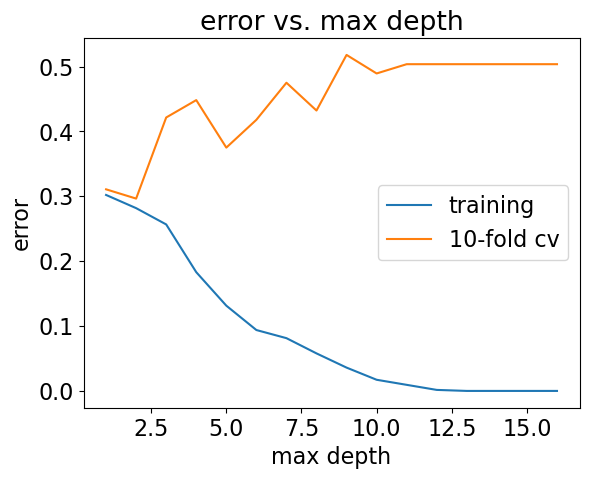

In [109]:
max_depths = np.arange(1, 17)
train_error = []
cv_error = []
for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    cv_scores = cross_validate(tree, X_train, y_train, cv=10, return_train_score=True)
    train_error.append(1 - cv_scores["train_score"].mean())
    cv_error.append(1 - cv_scores["test_score"].mean())

plt.plot(max_depths, train_error, label="training");
plt.plot(max_depths, cv_error, label="10-fold cv");
plt.xlabel("max depth");
plt.ylabel("error");
plt.title("error vs. max depth");
plt.legend();

- From now on, you should not make these kinds of plots with the test set.
- Make sure you do cross-validation on the training data.
- It's a bit unfortunate that they call it `"test_score"` in scikit-learn; for us this is a validation score. 

#### UBC CPSC 330 supervised learning workflow

1. Immediately split into train/test (before any exploratory data analysis).
2. Use cross-validation on the training split for your model validation.
3. Test your model once on the test set at the very end.

## True/False: cross-validation

1. $k$-fold cross validation calls `fit` $k$ times and `predict` $k$ times.
2. The goal of cross-validation is to obtain a better estimate of test error than just using a single validation set.
3. The main disadvantage of using a large $k$ in cross-validation is running time.
4. $2$-fold cross validation is the same thing as using a validation set that's 50% the size of your training set.

<br><br><br><br>

## Summary

- `train_test_split` randomly splits your data; set `random_state` to have the same split every time you run your code
- Overfitting: train score much better than validation/test score
- Underfitting: train score is poor, and is similar to validation/test score
- A nonzero "best error" exists because the targets are generally not a deterministic function of the features
- Fundamental tradeoff: as you move to more complex models your training score goes up but the train-test gap also goes up; test error may go up or down
- Validation data: used for hyperparameter tuning
- Test data: used for model assessment after tuning
- Deployment: when you are given some new X-values and you need to predict the corresponding targets for some (hopefully) useful purpose
- Cross-validation: better estimate of test score than just a regular validation set 
  - Pros: more accurate score estimates, thus better models; also gives a measure of uncertainty in the scores (more on this later)
  - Cons: makes code a bit more complicated, makes code slower
- First part of our standard recipe for supervised learning: train/test split, hyperparameter tuning with cross-validation, test on test set.